In [8]:
import numpy as np
import pandas as pd
import pingouin as pg
import nibabel as nb
from glob import glob
import seaborn as sns
import os
from mvpa.loading import load_betas
from utils import Options
from nilearn.image import new_img_like
from nilearn.plotting import plot_roi

In [5]:
def mask_functional_map(func, anat):
    """
    Simple helper function to mask a
    functional map using
    an anatomical one.
    """
    
    funcdata = func.get_fdata()
    anatdata = anat.get_fdata()
    
    masked = new_img_like(func, funcdata * anatdata)
    
    return masked

In [6]:
# General settings
subjlist = [f'sub-{i:03d}' for i in range(1, 36) if i != 6]
bidsdir = '../../bids/derivatives/spm-preproc/derivatives/roi-masks/'
LOC_template = '{:s}_LO_contr-objvscr_top-500.nii'
MT_mask = nb.load('../../anat_roi_masks/glasser-v5.nii')
MST_mask = nb.load('../../anat_roi_masks/glasser-MST.nii')

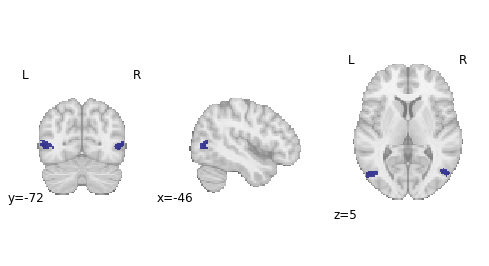

In [13]:
_ = plot_roi(MT_mask, draw_cross=False)

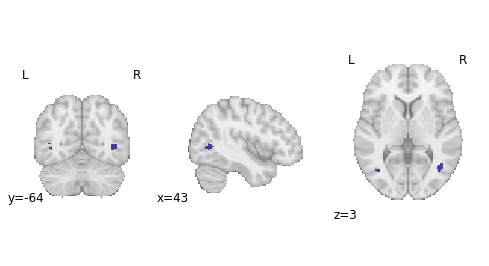

In [12]:
_ = plot_roi(MST_mask, draw_cross=False)

In [ ]:
# Get LOC, MT and MST average 
# for each subject
for s in subjlist: